# 🏞 합성곱 신경망

### 변경점
* 변경점 : 커스텀 데이터셋을 추가하는 방법에 대한 코드를 추가해 보았습니다.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

이 노트북에서는 CIFAR 데이터셋에서 합성곱 신경망(CNN)을 훈련하는 데 필요한 단계를 소개합니다.

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2024-01-25 21:07:26--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-01-25 21:07:26 (48.0 MB/s) - ‘utils.py’ saved [771/771]



In [20]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, utils, datasets
from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [3]:
NUM_CLASSES = 5

## 1. 데이터 준비 <a name="prepare"></a>
### 1) 데이터 불러오기 및 구조 확인

* 꽃의 종류를 분류하는 flowers 데이터셋을 구글 드라이브에 별도로 저장해 놓았습니다.
* 이를 불러와 구조를 확인해 보겠습니다.

In [4]:
# 구들 드라이브에 있는 데이터셋 가지오기
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
# 연동이 되었는지 확인
import os
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/스터디/notebooks/02_deeplearning/02_cnn/datasets")

['flowers']

* 데이터가 있는 것이 확인되었으니 경로를 설정합니다.

In [6]:
DATA_PATH = "/content/gdrive/MyDrive/Colab Notebooks/스터디/notebooks/02_deeplearning/02_cnn/datasets"

In [7]:
os.listdir(DATA_PATH+'/flowers')

['sunflower', 'tulip', 'rose', 'daisy', 'dandelion']

데이터의 구조를 확인해본 결과 다음과 같이 루트 디렉토리에서 각 범주(클래스별로) 폴더가 나뉘어 있으며,</br></br>
각 폴더의 내부에는 해당 범주에 속하는 이미지들이 저장되어 있습니다.

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

이와 같은 구조는 `keras.utils.image_dataset_from_directory`를 사용하면, 쉽게 불러오는 것이 가능합니다.

* 참고 : [`tf.keras.utils.image_data_from_directory`](https://tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [23]:
# 데이터셋 불러오기
from tensorflow.keras.utils import image_dataset_from_directory

dataset = image_dataset_from_directory(
    directory = os.path.join(DATA_PATH, 'flowers'),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [24]:
CLASS_NAMES = dataset.class_names

In [9]:
# 검증 데이터셋
val_dataset = image_dataset_from_directory(
    directory = os.path.join(DATA_PATH, 'flowers'),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=1,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear'
)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
(32, 256, 256, 3) (32, 5)
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(32, 5), dtype=float32)


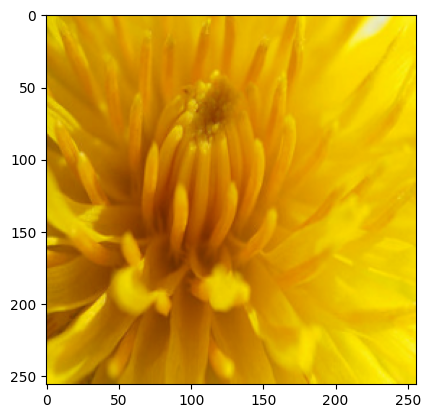

In [10]:
from matplotlib import pyplot as plt

# 클래스명 확인
print(dataset.class_names)
# 샘플 가져와보기
for data, label in dataset.take(1):
  print(data.shape, label.shape)
  print(label)
  plt.imshow(data[0].numpy().astype(np.uint8))

### 2) 간단한 전처리
불러오는 것은 문제가 없는 것이 확인되었으니, 용이한 학습이 가능하도록 정규화와 같은 간단한 전처리를 추가해 줍시다.
</br>
`keras.utils.image_dataset_from_directory`로 불러모아진 데이터셋은 `tensorflow.python.data.Dataset`이라는 객체의 인스턴스임을 활용하면 손쉬운 처리가 가능합니다.

In [11]:
# 범위 [0,255]에서 [0.,1.]로 정규화
def normalize_image(x, y):
  return x / 255.0, y

# 모든 데이터에 적용
dataset = dataset.map(normalize_image)

In [12]:
# 검증 데이터셋에도 적용
val_dataset = val_dataset.map(normalize_image)

In [13]:
# 확인
for data, label in dataset.take(1):
  data_numpy = data.numpy()
  print(np.min(data_numpy), np.max(data_numpy))

0.0 1.0


## 2. 모델 만들기 <a name="build"></a>

In [14]:
input_layer = layers.Input((256, 256, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.GlobalMaxPooling2D()(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                            

## 3. 모델 훈련 <a name="train"></a>

In [15]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [16]:
model.fit(
    dataset,
    epochs=10,
    validation_data=val_dataset,
)

Epoch 1/10
108/108 [==============================] - 48s 327ms/step - loss: 1.2813 - accuracy: 0.4737 - val_loss: 2.2199 - val_accuracy: 0.2364
Epoch 2/10
108/108 [==============================] - 28s 250ms/step - loss: 0.9786 - accuracy: 0.6132 - val_loss: 2.4112 - val_accuracy: 0.2364
Epoch 3/10
108/108 [==============================] - 28s 245ms/step - loss: 0.9134 - accuracy: 0.6471 - val_loss: 1.8355 - val_accuracy: 0.2793
Epoch 4/10
108/108 [==============================] - 26s 229ms/step - loss: 0.8517 - accuracy: 0.6711 - val_loss: 1.1986 - val_accuracy: 0.5006
Epoch 5/10
108/108 [==============================] - 24s 205ms/step - loss: 0.7932 - accuracy: 0.6908 - val_loss: 0.9098 - val_accuracy: 0.6385
Epoch 6/10
108/108 [==============================] - 34s 306ms/step - loss: 0.7595 - accuracy: 0.7125 - val_loss: 0.8276 - val_accuracy: 0.6802
Epoch 7/10
108/108 [==============================] - 32s 282ms/step - loss: 0.7081 - accuracy: 0.7322 - val_loss: 0.7987 - val_ac

## 4. 평가 <a name="evaluate"></a>

In [19]:
# 검증/시험 데이터셋에 평가 진행
model.evaluate(val_dataset)

863/863 [==============================] - 10s 11ms/step - loss: 0.7690 - accuracy: 0.7057


[0.7689515948295593, 0.70567786693573]

In [32]:
#@title **테스트 해보기**
#@markdown 이제 인터넷에서 이미지 url을 읽어와 제대로 분류하는지 테스트를 진행해 봅시다.</br>

import os
import subprocess

#@markdown 테스트를 진행할 이미지 url을 아래에 입력해 주세요.

url = "https://upload.wikimedia.org/wikipedia/commons/e/e7/Leucanthemum_vulgare_%27Filigran%27_Flower_2200px.jpg" #@param {type:"string"}
answer = "daisy" #@param {type:"string"}

try:
  if url == "" or url == None:
    raise ValueError('Please enter url')
  else:
    # 파일 읽어오기
    # url에 파일을 다운 후, test_path에 다운받은 경로가 문자열로 저장됨
    test_path = tf.keras.utils.get_file(
        fname="test."+url.split('.')[-1],
        origin=url
    )
    # 저장된 이미지 로드
    test_img = tf.keras.utils.load_img(
        test_path,
        grayscale=False,
        target_size=(256,256))
    test_img = tf.keras.utils.img_to_array(test_img) # numpy 배열로 형변환
    test_img /= 255.0 # 정규화
    test_img = np.array([test_img]) # 모델 입력을 위해 1차원 확장
    prediction = model.predict(test_img) # 예측 진행
    pred_idx = np.argmax(prediction, axis=1)[0] # one-hot encoding -> predicted label index
    pred_class = CLASS_NAMES[pred_idx] # predicted label index -> predicted label class
    print(f'Prediction : {pred_class}')
    print(f'Label : {answer}')

except Exception as e:
  print(e)

1/1 [==============================] - 0s 19ms/step
Prediction : daisy
Label : daisy


(-0.5, 255.5, 255.5, -0.5)

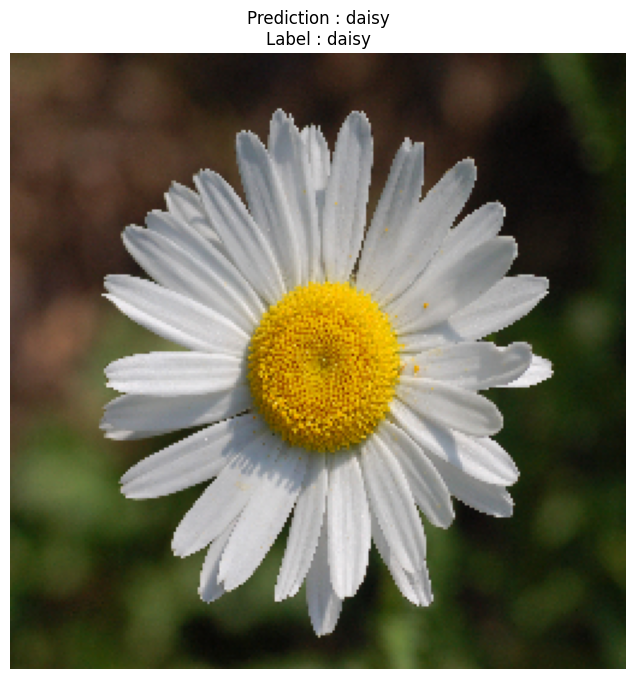

In [34]:
# 시각화 해봅시다

def denormalize(x):
  return (x * (2**8 - 1)).astype(np.uint8)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(denormalize(test_img[0]))
ax.set_title(f'Prediction : {pred_class}\nLabel : {answer}')
ax.axis('off')

이로써 **`keras`** 의 이미지 데이터용 Generator를 사용하여 이미지 분류 모델 훈련 및 평가 그리고 테스트까지 진행하여보았습니다.</br>
데이터셋을 변경하여 훈련을 진행시켜 보세요!